<a href="https://colab.research.google.com/github/vggls/M.Sc._AI_Thesis/blob/main/experiments/breakhis_resnet50/Examples_of_HA_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Imports**

In [ ]:
pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38262 sha256=cde10991523fb31bd1b8e0bd259cc77192d722fbb268695f79f284afa4dd8168
  Stored in directory: /root/.cache/pip/wheels/9b/ae/bd/221d138b169c4867b2ae5c893474d0b23bae6e4750bc95bc55
Successfully built grad-cam


In [ ]:
import matplotlib.pyplot as plt

import torch
from torchvision  import datasets, transforms

from pytorch_grad_cam import GradCAM, HiResCAM

In [ ]:
# custom written code 
from breakhis_slide_allocation import allocate_slides_to_datasets
from breakhis_binary import create_datasets, summaries
from haas import HA_image
from plot_tensor import convert_for_plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Download from Kaggle**

In [ ]:
! mkdir ~/.kaggle/
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download ambarish/breakhis

100% 3.99G/3.99G [03:14<00:00, 22.8MB/s]
100% 3.99G/3.99G [03:14<00:00, 22.0MB/s]


In [ ]:
! unzip breakhis.zip

# **3. Test dataset**

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])
# to be applied to validation and test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])

In [ ]:
training_dataset, validation_dataset, test_dataset = create_datasets(train_transforms, test_transforms)

No benign slides overlap in training, validation and test sets!
No malignant slides overlap in training, validation and test sets!


# **4. ResNet50 - HA images**

In [ ]:
drive_path = './drive/MyDrive/Colab_Notebooks/dataset_models/BreakHis/Models/'
resnet50 = torch.load(drive_path + 'breakhis_resnet50.pt')
resnet50 = resnet50.eval()

In [ ]:
gradcam_instance = GradCAM(model=resnet50, target_layers=[resnet50.layer4[2].conv3], use_cuda=True)
hirescam_instance = HiResCAM(model=resnet50, target_layers=[resnet50.layer4[2].conv3], use_cuda=True)

In [ ]:
unfreeze = [resnet50.conv1, resnet50.bn1, resnet50.layer1, resnet50.layer2, resnet50.layer3, resnet50.layer4]
for child in unfreeze:
    for param in child.parameters():
        param.requires_grad = True

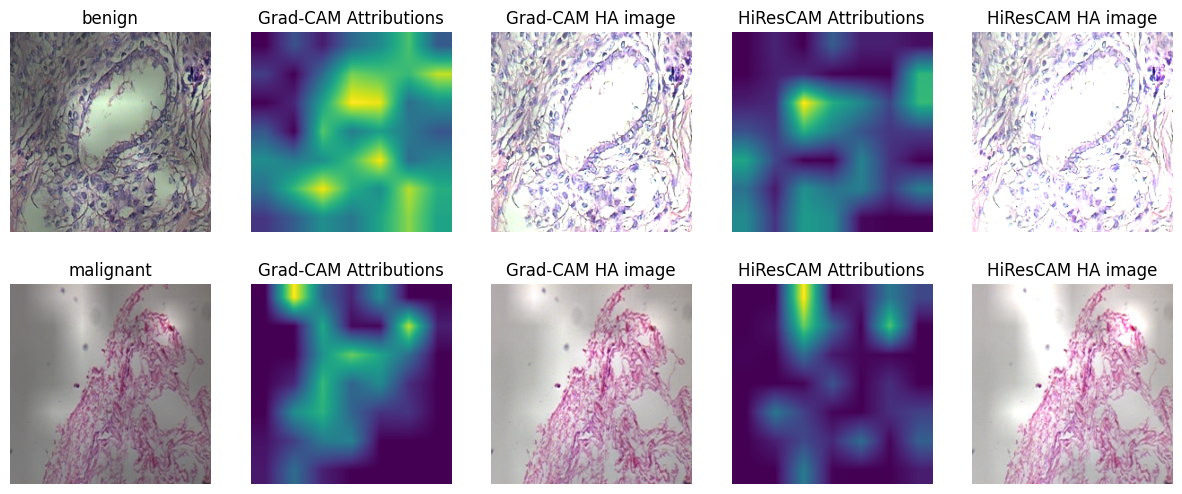

In [ ]:
labels = test_dataset.class_to_idx.values()

fig, ax = plt.subplots(2, 5, figsize=(15, 6))

for label in labels:

    tensor, label = [(a,b) for (a,b) in test_dataset if (b==label and label == int(torch.argmax(resnet50(a.cuda().unsqueeze(0)))))][80]
    tensor = tensor.cuda()
    
    gradcam_attributions = gradcam_instance(tensor.unsqueeze(0))[0,:,:]
    hirescam_attributions = hirescam_instance(tensor.unsqueeze(0))[0,:,:]

    ha_gradcam_tensor = HA_image(tensor, gradcam_attributions)
    ha_hirescam_tensor = HA_image(tensor, hirescam_attributions)

    ax[label, 0].imshow(convert_for_plot(tensor))
    ax[label, 0].set_title('{}'.format(list(test_dataset.class_to_idx.keys())[list(test_dataset.class_to_idx.values()).index(label)])); ax[label, 0].axis('off')

    ax[label, 1].imshow(gradcam_attributions); ax[label,1].set_title('Grad-CAM Attributions'); ax[label, 1].axis('off')

    ax[label, 2].imshow(convert_for_plot(ha_gradcam_tensor)); ax[label,2].set_title('Grad-CAM HA image'); ax[label, 2].axis('off')

    ax[label, 3].imshow(hirescam_attributions); ax[label,3].set_title('HiResCAM Attributions'); ax[label, 3].axis('off')

    ax[label, 4].imshow(convert_for_plot(ha_hirescam_tensor)); ax[label,4].set_title('HiResCAM HA image'); ax[label, 4].axis('off')